# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

In [3]:
function indicator(x, a, b)
    k = 100 
    g1 = 1 / (1 + exp(-k * (x - a)))  
    g2 = 1 / (1 + exp(-k * (b - x)))  
    return g1 * g2
end
fNC(x)  = indicator(x, 0.5, 3.5) ;
fC(x)  = (1. - fNC(x))
plot(fC, -1., 5);

In [4]:
function ZERMELO(x0, ε; solution=[], nsteps=500, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                x1[1:N+1]    
                x2[1:N+1]   
        -π/2  ≤  λ[1:N+1]  ≤ π/2
        -π/2  ≤  u[1:N+1]  ≤ π/2
        -1e1  ≤   v[1:N+1] ≤ 1e1 
         -1e1  ≤ xv[1:N+1]
         -1e1  ≤ xu[1:N+1]
    end)
    
    
    Δt = 8/(N+1) ;
    
    # Objective
    @NLobjective(sys, Min, - x1[N+1] + ε*xv[N+1] + xu[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x2f, x2[N+1] == 4.0                  
        con_x30, -π/2 <= λ[1]    <= π/2
        con_x3f, -π/2 <= λ[N+1]  <= π/2
        end)
    
    # Dynamics

    @NLexpression(sys, dx1[j = 1:N+1], fNC(x2[j])*(x2[j] + cos(λ[j])) + fC(x2[j])*(x2[j] + cos(u[j])))
    
    @NLexpression(sys, dx2[j = 1:N+1], fNC(x2[j])*sin(λ[j]) + fC(x2[j])*sin(u[j]) )
    
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x2[j])*v[j])
    
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x2[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

   
    return Direct(t, x1, x2, λ, u, xu, xv, p1, p2)
        
end;
     

In [5]:
# Resolution
x0  = [0.0; 0.0]
ε   = 1e-3
sol_direct = ZERMELO(x0, ε, nsteps=600);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18005
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    20400

Total number of variables............................:     4207
                     variables with only lower bounds:     1202
                variables with lower and upper bounds:     1803
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3005
Total number of in

  (Local) solution found
  objective value = -30.293547823708728



┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.03117672874877222
xv = 0.04029414104986509


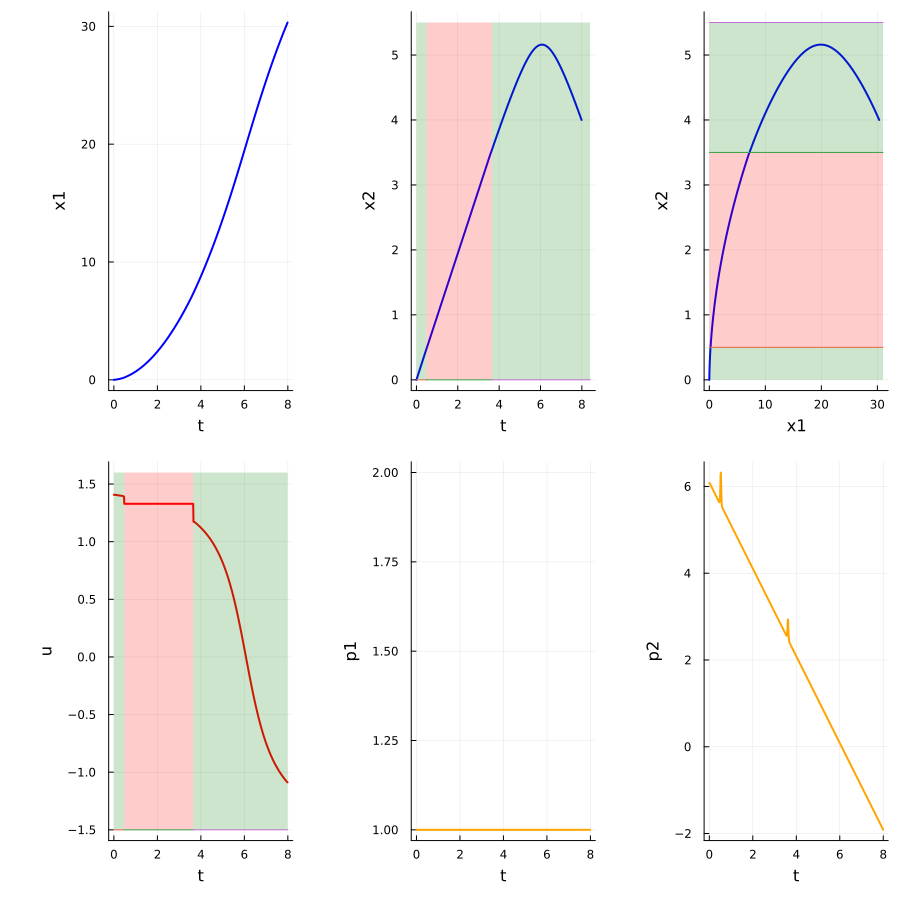

In [44]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
λ  = sol_direct.λ
xu = sol_direct.xu
xv = sol_direct.xv
p1 = sol_direct.p1
p2 = sol_direct.p2

println("xu = ", xu[end])
println("xv = ", xv[end])

u1   = copy(u) ; 
zero = findall(abs.(u1) .< 0.01)
t1   = t[37]
t2   = t[275]
u1[t1  .<= t .<= t2] .= λ[200]


x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend= false, linecolor=:blue, linewidth=2)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1",  legend= false, linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2",  legend= false, linecolor=:orange, linewidth=2)

x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", legend= false,linecolor=:blue,linewidth=2)
plot!(x2_plot, [0.0, t1], [0, 0],    fillrange = 5.5, fillalpha = 0.2, fillcolor = :green)
plot!(x2_plot, [t1, t2],  [0, 0],     fillrange = 5.5, fillalpha = 0.2, fillcolor = :red)
plot!(x2_plot, [t2, 8.4], [0, 0],     fillrange = 5.5, fillalpha = 0.2, fillcolor = :green)



u_plot   = plot(t,  u1, xlabel = "t", ylabel = "u",legend= false,linecolor=:red,linewidth=2)
plot!(u_plot, [0.0, t1], [-1.5, -1.5],    fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)
plot!(u_plot, [t1, t2], [-1.5, -1.5],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :red)
plot!(u_plot, [t2, t[end]], [-1.5, -1.5],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)


λ_plot   = plot(t,  λ, xlabel = "t", ylabel = "λ", legend= false,linecolor=:red,linewidth=2)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend= false, linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)
plot!(x1x2_plot, [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green)


plot(x1_plot, x2_plot, x1x2_plot, u_plot , p1_plot, p2_plot , layout = (2,3), size=(900,900), left_margin=10mm)

In [7]:
jmp1 = p2[43]  - p2[40]
jmp2 = p2[270] - p2[264];

# Indirect method

In [8]:
using NLsolve
using Animations
using Reel
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [9]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [ sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region
H2(x, λ, y, p)   = p' * F(x, λ)   + y* p' *G(λ)          # pseudo-Hamiltonian
Hcl(X, P)     = H2(X[1:2], X[3], X[4], P[1:2])           # control loss

# Flows
fcl  = Flow(Hcl);

In [10]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, λ, jump1, jump2) 
    
    pλ0    = 0.0 
    
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    X2, P2 = fcl(tt1, [x1; λ ; 0.0], [p1 - [0. , jump1]; pλ0 ; py0], tt2) # flow augmenté
    
    xf, pf = fc(tt2, X2[1:2], P2[1:2] - [0. , jump2], tf)

    s = zeros(eltype(p0), 7)
    s[1]  = xf[2] - x2f # target
    s[2]  = pf[1] - 1.0 # transversality condition
    s[3]  = x1[2] - 0.5 # first crossing 
    s[4]  = X2[2] - 3.5 # second crossing 
    s[5]  = P2[4]       # averaged gradient condition
    s[6]  = jump1 - p1[2]*(λ - u11(x1, p1))/(λ - x1[1])                # jump 1
    s[7]  = jump2 - P2[2]*(u11(X2[1:2], P2[1:2]) - λ)/(λ - X2[1])      # jump 2

    
    return s

end;

In [11]:
S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7]) ;

In [12]:
ξ_guess = [p1[1], p2[1], t1[1], t2[1], λ[100], jmp1, jmp2] ; # initial guess

In [13]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[1.04073466211016, 0.0, -0.027688346012475273, 0.047833271019910306, 0.40558004050324353, -0.24190399830708026, -0.05140387662005609]




In [14]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0   = indirect_sol.zero[1:2]
    tt1   = indirect_sol.zero[3]
    tt2   = indirect_sol.zero[4]
    a     = indirect_sol.zero[5]
    jmp11 = indirect_sol.zero[6]
    jmp22 = indirect_sol.zero[7]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.040735e+00              NaN
     1     2.346248e-02     3.834734e-01
     2     5.768353e-05     1.821584e-02
     3     1.732964e-10     1.028312e-05
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.077780375252453, 0.47920133111480867, 3.6472545757071546, 1.3285112688044949, -0.5653364873640907, -0.011477446829007754]
 * Zero: [1.0, 5.864224581803904, 0.5078962137989285, 3.5966874726839415, 1.3304421275322573, -0.2681653614210989, 0.05916036980091708]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


In [15]:
tt1 - t1[1]

0.028694882684119793

In [16]:
tt2 - t2[1]

-0.0505671030232131

In [17]:
λ[100] - a

-0.0019308587277624412

In [18]:
jmp1 - jmp11

-0.2971711259429918

In [19]:
jmp2 - jmp22

-0.07063781662992483

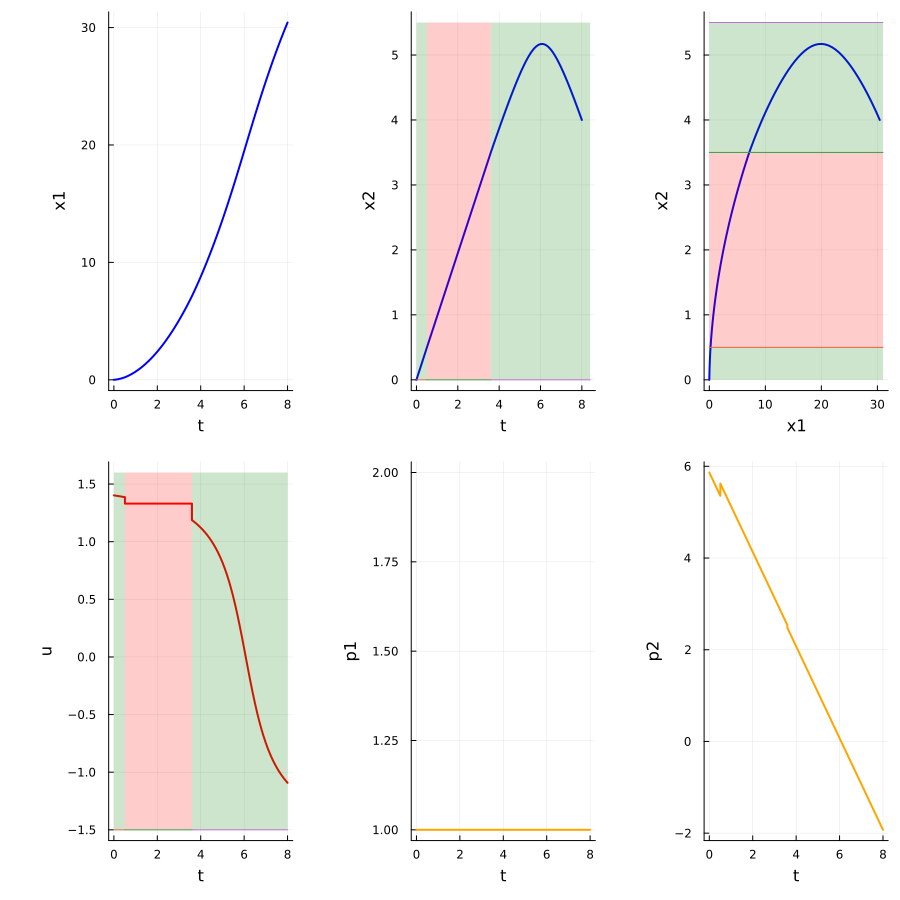

In [49]:
ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = u11.(xx1, pp1)  ;

pλ0 = 0. 
py0 = 0.

ode_sol = fcl((tt1, tt2), [xx1[end] ; a ; 0.0], [pp1[end] - [0. , jmp11]; pλ0 ; py0], saveat=0.1)
ttt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2 = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2 = a.*ones(length(ttt2)) ;

ode_sol = fc((tt2, tf), xx2[end], pp2[end] - [0. , jmp22], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend= false, linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", legend= false,linecolor=:blue,linewidth=2)
plot!(x2_plot, [0.0, tt1], [0, 0],    fillrange = 5.5, fillalpha = 0.2, fillcolor = :green)
plot!(x2_plot, [tt1, tt2],  [0, 0],     fillrange = 5.5, fillalpha = 0.2, fillcolor = :red)
plot!(x2_plot, [tt2, 8.4], [0, 0],     fillrange = 5.5, fillalpha = 0.2, fillcolor = :green)


p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend= false,linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2",legend= false,linecolor=:orange,linewidth=2)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",  legend= false,linecolor=:red ,linewidth=2) 
plot!(u_plot, [0.0, tt1], [-1.5, -1.5],    fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)
plot!(u_plot, [tt1, tt2], [-1.5, -1.5],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :red)
plot!(u_plot, [tt2, 8.], [-1.5, -1.5],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)



x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend= false, linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)
plot!(x1x2_plot, [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green)

x =plot(x1_plot, x2_plot,x1x2_plot,u_plot,p1_plot, p2_plot , layout = (2, 3), size=(900,900), left_margin=10mm)




In [68]:
 # create an animation
#animx = @animate for i = 1:length(t)
#    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(0.,7.), xlabel="x1", ylabel="x2", label="trajectory", linecolor=:blue)
#end

# create an animation
#animu = @animate for i = 1:length(t)
#    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="control", linecolor=:red)
#end ;

In [69]:
# display the animation
#gif(animx, "animationx.gif", fps = 15)

In [70]:
#gif(animu, "animationx.gif", fps = 15)